# ASL Word-Level Recognition with CNN

This notebook implements a visual stream CNN model for American Sign Language (ASL) word-level recognition. 
The model takes frame inputs extracted from videos and classifies them into specific ASL words.

**Project Overview:**
- We're using pre-processed frames from the WLASL (Word-Level American Sign Language) dataset
- A lightweight CNN model (MobileNetV2) will be trained for classification
- The model is optimized for low-latency inference
- Each class directory contains images for a specific word sign
- Added Optuna for hyperparameter optimization
- Added checkpoint management for training resumption


In [30]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import json
from pathlib import Path
from datetime import datetime
import random  # Also needed for the unique study name generation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchmetrics

# For hyperparameter optimization
import optuna
from optuna.trial import TrialState

# Enable GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


# Data Loading and Exploration

Let's first set up our paths and parameters, then explore the dataset structure to understand what we're working with.


In [4]:
# Configure paths and parameters
DATA_ROOT = Path("/kaggle/input/wsl300processed/processed")  # Adjust if necessary
OUTPUT_DIR = Path("/kaggle/working/output")
CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
OUTPUT_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

# Default hyperparameters (will be optimized later)
DEFAULT_PARAMS = {
    'batch_size': 32,
    'img_size': 224,
    'num_epochs': 20,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'dropout_rate': 0.2,
    'num_workers': 4  # For data loading (adjust based on your system)
}

# Create a timestamp for model versioning
timestamp = time.strftime("%Y%m%d_%H%M%S")


Total number of classes: 300

Sample classes:
  - live: 127 samples
  - person: 174 samples
  - internet: 175 samples
  - theory: 157 samples
  - interest: 191 samples

Total samples across all classes: 56578


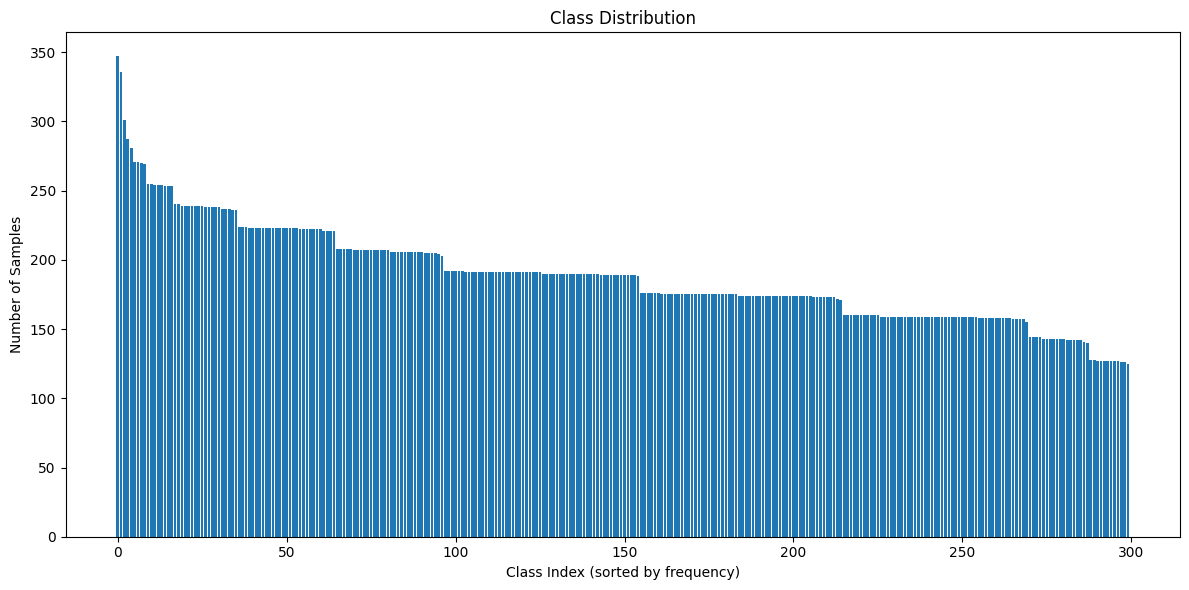


First 10 classes in mapping:
  about: 0
  accident: 1
  africa: 2
  again: 3
  all: 4
  always: 5
  animal: 6
  apple: 7
  approve: 8
  argue: 9


In [5]:
# Explore dataset structure
class_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])
print(f"Total number of classes: {len(class_dirs)}")

# Sample a few classes
sample_classes = random.sample(class_dirs, min(5, len(class_dirs)))
print("\nSample classes:")
for class_dir in sample_classes:
    num_samples = len(list(class_dir.glob("*/*jpg")))
    print(f"  - {class_dir.name}: {num_samples} samples")

# Get class distribution
class_counts = {}
total_samples = 0
for class_dir in class_dirs:
    count = len(list(class_dir.glob("*/*jpg")))
    class_counts[class_dir.name] = count
    total_samples += count

print(f"\nTotal samples across all classes: {total_samples}")

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), sorted(class_counts.values(), reverse=True))
plt.xlabel('Class Index (sorted by frequency)')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

# Create class mapping
class_to_idx = {cls.name: i for i, cls in enumerate(sorted(class_dirs))}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

print(f"\nFirst 10 classes in mapping:")
for i, (cls, idx) in enumerate(list(class_to_idx.items())[:10]):
    print(f"  {cls}: {idx}")


# Data Preprocessing and Augmentation

Now let's create our data loading pipeline with appropriate augmentations. 
We'll need to implement:
1. A custom dataset class to handle our image structure
2. Data transformations including augmentations for training
3. Data loaders for efficient batch processing


In [6]:
# Function to get data transforms (parameterized for hyperparameter tuning)
def get_data_transforms(img_size):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform


In [7]:
# Create custom dataset for our frame structure
class ASLFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, class_to_idx=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        # Collect all image paths and their labels
        self.samples = []
        
        if class_to_idx is None:
            classes = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])
            self.class_to_idx = {cls.name: i for i, cls in enumerate(classes)}
        else:
            self.class_to_idx = class_to_idx
            
        # Get all image paths and their corresponding labels
        for class_dir in [d for d in self.root_dir.iterdir() if d.is_dir()]:
            class_idx = self.class_to_idx.get(class_dir.name)
            if class_idx is not None:  # Skip if not in our class mapping
                for video_dir in class_dir.iterdir():
                    if video_dir.is_dir():
                        for img_path in video_dir.glob("*.jpg"):
                            self.samples.append((img_path, class_idx))
        
        print(f"Loaded {len(self.samples)} images from {len(self.class_to_idx)} classes")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [8]:
# Function to create datasets and dataloaders (parameterized for hyperparameter tuning)
def create_dataloaders(batch_size, img_size, num_workers):
    # Get transforms
    train_transform, val_transform = get_data_transforms(img_size)
    
    # Create dataset
    dataset = ASLFrameDataset(DATA_ROOT, transform=val_transform, class_to_idx=class_to_idx)

    # Calculate split sizes
    total_size = len(dataset)
    val_size = int(0.2 * total_size)  # 20% for validation
    train_size = total_size - val_size

    # Split the dataset
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )

    # Apply appropriate transforms to each split
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, train_dataset, val_dataset


# Visualize Sample Images

Let's create data loaders with default parameters and visualize a few sample images.


Loaded 56578 images from 300 classes
Training samples: 45263
Validation samples: 11315
Number of classes: 300


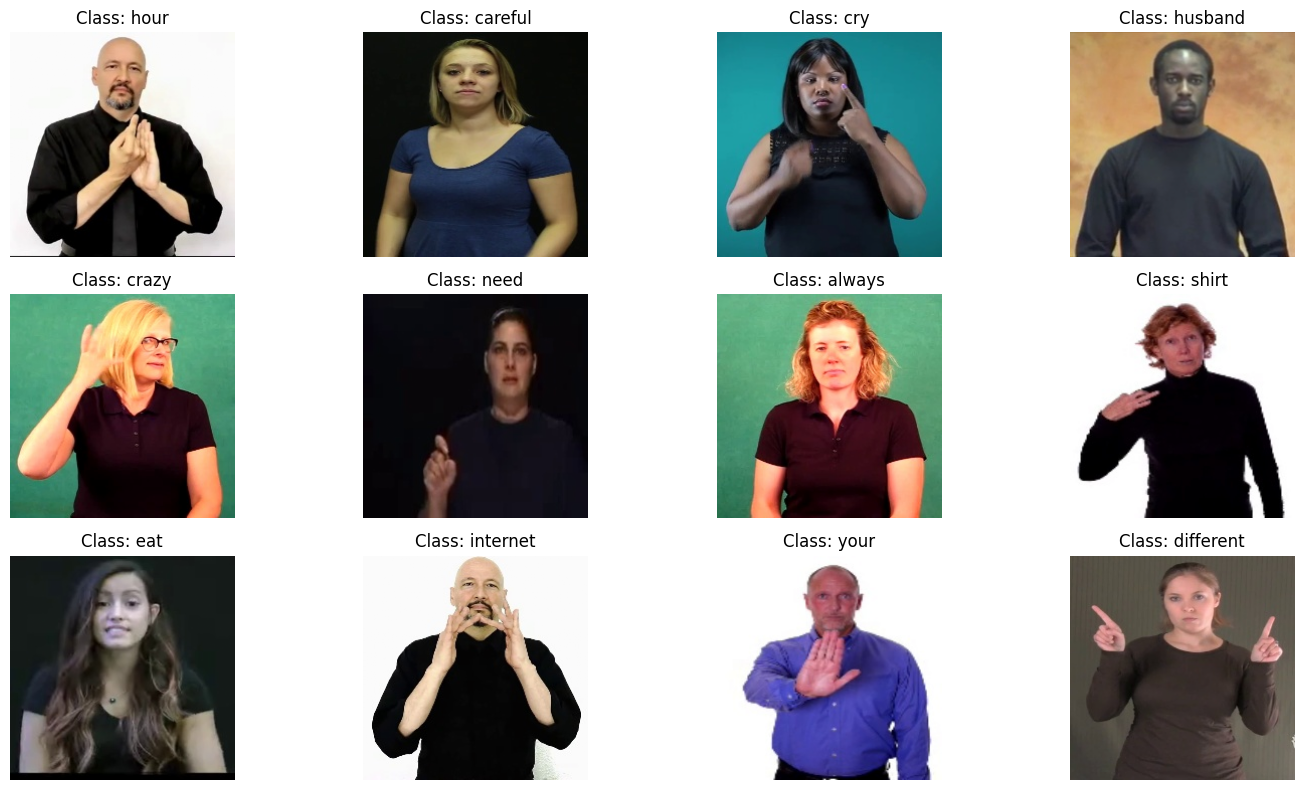

In [9]:
# Create dataloaders with default parameters
train_loader, val_loader, train_dataset, val_dataset = create_dataloaders(
    DEFAULT_PARAMS['batch_size'], 
    DEFAULT_PARAMS['img_size'],
    DEFAULT_PARAMS['num_workers']
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(class_to_idx)}")

# Function to denormalize tensor images for display
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot some sample images
plt.figure(figsize=(15, 8))
for i in range(min(12, len(images))):
    plt.subplot(3, 4, i+1)
    img = denormalize(images[i]).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    class_name = idx_to_class[labels[i].item()]
    plt.title(f"Class: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Model Architecture

Now we'll define our CNN model architecture with configurable parameters for hyperparameter optimization.


In [10]:
# Define the CNN model using MobileNetV2 as backbone
class ASLRecognitionModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2, pretrained=True):
        super(ASLRecognitionModel, self).__init__()
        # Load the pretrained MobileNetV2 model
        self.backbone = models.mobilenet_v2(pretrained=pretrained)
        
        # Replace the last fully connected layer
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)


# Training and Validation Functions

Let's define our training and evaluation functions with checkpoint management.


In [11]:
# Training function with checkpoint management
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create progress tracking
    progress_interval = max(1, len(dataloader) // 5)  # Report 5 times per epoch
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Report progress
        if (batch_idx + 1) % progress_interval == 0:
            print(f"Epoch [{epoch+1}/{total_epochs}] Batch [{batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100. * correct / total:.2f}%")
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Function to save checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, train_acc, 
                    val_loss, val_acc, best_val_loss, params, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'best_val_loss': best_val_loss,
        'params': params,
        'class_to_idx': class_to_idx
    }
    torch.save(checkpoint, filename)

# Function to load checkpoint
def load_checkpoint(filename, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return (checkpoint['epoch'], checkpoint['train_loss'], checkpoint['train_acc'],
            checkpoint['val_loss'], checkpoint['val_acc'], checkpoint['best_val_loss'],
            checkpoint['params'], checkpoint['class_to_idx'])


# Training Function with Checkpoint Management

Here's our main training function that includes checkpoint management for resuming training.


In [12]:
# Main training function
def train_model(params, resume_from=None):
    # Create dataloaders
    train_loader, val_loader, _, _ = create_dataloaders(
        params['batch_size'], params['img_size'], params['num_workers']
    )
    
    # Initialize model
    model = ASLRecognitionModel(
        num_classes=len(class_to_idx), 
        dropout_rate=params['dropout_rate']
    )
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'], 
        weight_decay=params['weight_decay']
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )
    
    # Initialize history and best values
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    start_epoch = 0
    
    # Resume from checkpoint if specified
    if resume_from:
        print(f"Resuming from checkpoint: {resume_from}")
        start_epoch, train_loss, train_acc, val_loss, val_acc, best_val_loss, loaded_params, _ = load_checkpoint(
            resume_from, model, optimizer, scheduler
        )
        # Update parameters from checkpoint if needed
        for key in loaded_params:
            if key not in params:
                params[key] = loaded_params[key]
        
        # Append previous metrics to history
        history['train_loss'].extend([train_loss])
        history['train_acc'].extend([train_acc])
        history['val_loss'].extend([val_loss])
        history['val_acc'].extend([val_acc])
        
        start_epoch += 1  # Start from next epoch
    
    # Define checkpoint paths
    checkpoint_path = CHECKPOINT_DIR / f"asl_checkpoint_{timestamp}.pth"
    best_model_path = CHECKPOINT_DIR / f"asl_best_{timestamp}.pth"
    final_model_path = OUTPUT_DIR / f"asl_recognition_final_{timestamp}.pth"
    
    # Training loop
    print(f"Starting training from epoch {start_epoch + 1}...")
    for epoch in range(start_epoch, params['num_epochs']):
        # Train one epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch, params['num_epochs']
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{params['num_epochs']}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save regular checkpoint
        save_checkpoint(
            model, optimizer, scheduler, epoch, train_loss, train_acc,
            val_loss, val_acc, best_val_loss, params, checkpoint_path
        )
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(
                model, optimizer, scheduler, epoch, train_loss, train_acc,
                val_loss, val_acc, best_val_loss, params, best_model_path
            )
            print(f"Saved best model at epoch {epoch+1}")
    
    # Save final model
    save_checkpoint(
        model, optimizer, scheduler, params['num_epochs']-1, 
        history['train_loss'][-1], history['train_acc'][-1],
        history['val_loss'][-1], history['val_acc'][-1], 
        best_val_loss, params, final_model_path
    )
    print("Training complete!")
    
    return history, best_val_loss, best_model_path


# Hyperparameter Optimization with Optuna

Let's use Optuna to find the optimal hyperparameters for our model.


In [13]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'img_size': trial.suggest_categorical('img_size', [224, 240]),
        'num_epochs': 5,  # Use fewer epochs for hyperparameter search
        'num_workers': DEFAULT_PARAMS['num_workers']
    }
    
    # Create dataloaders
    train_loader, val_loader, _, _ = create_dataloaders(
        params['batch_size'], params['img_size'], params['num_workers']
    )
    
    # Initialize model
    model = ASLRecognitionModel(
        num_classes=len(class_to_idx), 
        dropout_rate=params['dropout_rate']
    )
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'], 
        weight_decay=params['weight_decay']
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=2, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    
    for epoch in range(params['num_epochs']):
        # Train one epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch, params['num_epochs']
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Report intermediate metric
        trial.report(val_loss, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    
    return best_val_loss


# Run Hyperparameter Optimization

Let's run Optuna to find the best hyperparameters.


In [28]:
def run_hyperparameter_optimization(n_trials=20):
    """Run hyperparameter optimization using Optuna."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    study_name = f"asl_recognition_study_{timestamp}"
    storage_name = f"sqlite:///{study_name}.db"
    
    # Add load_if_exists=True to reuse the study if it exists
    try:
        study = optuna.create_study(
            study_name=study_name,
            storage=storage_name,
            direction="minimize",  # We want to minimize validation loss
            load_if_exists=True,   # This will reuse the existing study if it exists
        )
    except:
        # If there's still an issue, create with a unique name
        unique_study_name = f"asl_recognition_study_{timestamp}_{random.randint(1000, 9999)}"
        storage_name = f"sqlite:///{unique_study_name}.db"
        study = optuna.create_study(
            study_name=unique_study_name,
            storage=storage_name,
            direction="minimize",
        )
    
    print(f"Running hyperparameter optimization with {n_trials} trials...")
    study.optimize(lambda trial: objective(trial), n_trials=n_trials)
    
    best_params = study.best_params
    best_params['num_workers'] = DEFAULT_PARAMS['num_workers']  # Add default num_workers
    
    print("\nBest hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    return best_params

In [15]:
# Function to evaluate the best model
def evaluate_model(model_path):
    # Load best model and parameters
    checkpoint = torch.load(model_path)
    model = ASLRecognitionModel(
        num_classes=len(class_to_idx), 
        dropout_rate=checkpoint['params']['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    print(f"Loaded model from {model_path}")
    print(f"Model was trained for {checkpoint['epoch'] + 1} epochs")
    print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")
    
    # Create dataloaders with the same parameters
    _, val_loader, _, _ = create_dataloaders(
        checkpoint['params']['batch_size'], 
        checkpoint['params']['img_size'],
        checkpoint['params']['num_workers']
    )
    
    # Function to get all predictions
    def get_all_predictions(model, dataloader, device):
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return np.array(all_preds), np.array(all_labels)
    
    # Get predictions
    print("Getting predictions for validation set...")
    y_pred, y_true = get_all_predictions(model, val_loader, device)
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix for the top classes
    top_n_classes = 15  # Adjust based on your needs
    plt.figure(figsize=(12, 10))
    
    # Get classes with most samples
    top_class_indices = np.argsort([class_counts[idx_to_class[i]] for i in range(len(class_to_idx))])[-top_n_classes:]
    top_classes = [idx_to_class[i] for i in top_class_indices]
    
    # Filter confusion matrix for top classes
    top_conf_matrix = conf_matrix[np.ix_(top_class_indices, top_class_indices)]
    
    # Plot
    plt.imshow(top_conf_matrix, cmap='Blues')
    plt.colorbar()
    plt.xticks(np.arange(len(top_classes)), top_classes, rotation=90)
    plt.yticks(np.arange(len(top_classes)), top_classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Top Classes')
    
    # Add text annotations
    thresh = top_conf_matrix.max() / 2
    for i in range(len(top_classes)):
        for j in range(len(top_classes)):
            plt.text(j, i, top_conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if top_conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"confusion_matrix_{timestamp}.png")
    plt.close()
    
    # Print classification report
    print("Classification Report:")
    report = classification_report(
        y_true, y_pred, 
        target_names=[idx_to_class[i] for i in range(len(class_to_idx))],
        output_dict=True
    )
    
    # Save classification report
    report_file = OUTPUT_DIR / f"classification_report_{timestamp}.json"
    with open(report_file, 'w') as f:
        # Convert numpy values to float for JSON serialization
        for class_name in report:
            if isinstance(report[class_name], dict):
                for metric in report[class_name]:
                    report[class_name][metric] = float(report[class_name][metric])
            else:
                report[class_name] = float(report[class_name])
        json.dump(report, f, indent=4)
    
    # Print text report as well
    print(classification_report(
        y_true, y_pred, 
        target_names=[idx_to_class[i] for i in range(len(class_to_idx))]
    ))
    
    # Measure inference time
    def measure_inference_time(model, input_size=(1, 3, 224, 224), num_iterations=100):
        model.eval()
        
        # Create random input tensor
        img_size = checkpoint['params'].get('img_size', 224)
        dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
        
        # Warm-up
        with torch.no_grad():
            for _ in range(10):
                _ = model(dummy_input)
        
        # Measure time
        start_time = time.time()
        with torch.no_grad():
            for _ in range(num_iterations):
                _ = model(dummy_input)
        end_time = time.time()
        
        avg_time = (end_time - start_time) / num_iterations
        return avg_time * 1000  # Convert to milliseconds
    
    # Measure inference time
    inference_time = measure_inference_time(model)
    fps = 1000 / inference_time
    
    print(f"Average inference time: {inference_time:.2f} ms")
    print(f"Frames per second: {fps:.2f}")
    
    # Export model to TorchScript format for deployment
    def export_to_torchscript(model, img_size):
        model.eval()
        example_input = torch.rand(1, 3, img_size, img_size).to(device)
        traced_model = torch.jit.trace(model, example_input)
        torch_script_path = OUTPUT_DIR / f"asl_torchscript_{timestamp}.pt"
        traced_model.save(str(torch_script_path))
        print(f"Exported TorchScript model to {torch_script_path}")
        return torch_script_path
    
    # Export model
    img_size = checkpoint['params'].get('img_size', 224)
    torchscript_path = export_to_torchscript(model, img_size)
    
    return torchscript_path


In [16]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"training_metrics_{timestamp}.png")
    plt.close()


# Execution

In [25]:
# Section 1: Setup and initialization
if __name__ == "__main__":
    print("=" * 50)
    print("ASL Word-Level Recognition with CNN")
    print("=" * 50)
    
    # Check if we should resume from checkpoint
    resume_from = None
    checkpoints = list(CHECKPOINT_DIR.glob("*.pth"))
    if checkpoints:
        print("\nFound existing checkpoints:")
        for i, ckpt in enumerate(checkpoints):
            print(f"{i+1}. {ckpt.name}")
        
        choice = input("\nResume from checkpoint? (Enter number or 'n' to start fresh): ")
        if choice.isdigit() and 1 <= int(choice) <= len(checkpoints):
            resume_from = checkpoints[int(choice) - 1]
            print(f"Will resume from {resume_from}")
    
    # Check if we want to use Optuna
    use_optuna = True
    n_trials = 20
    if resume_from is None:  # Only ask if not resuming
        choice = input("\nUse Optuna for hyperparameter optimization? (y/n, default: y): ")
        use_optuna = choice.lower() != 'n'
        if use_optuna:
            n_trials = int(input("\nNumber of Optuna trials (default: 20): ") or "20")


ASL Word-Level Recognition with CNN



Use Optuna for hyperparameter optimization? (y/n, default: y):  y

Number of Optuna trials (default: 20):  3


Loaded 56578 images from 300 classes

Visualizing sample images...


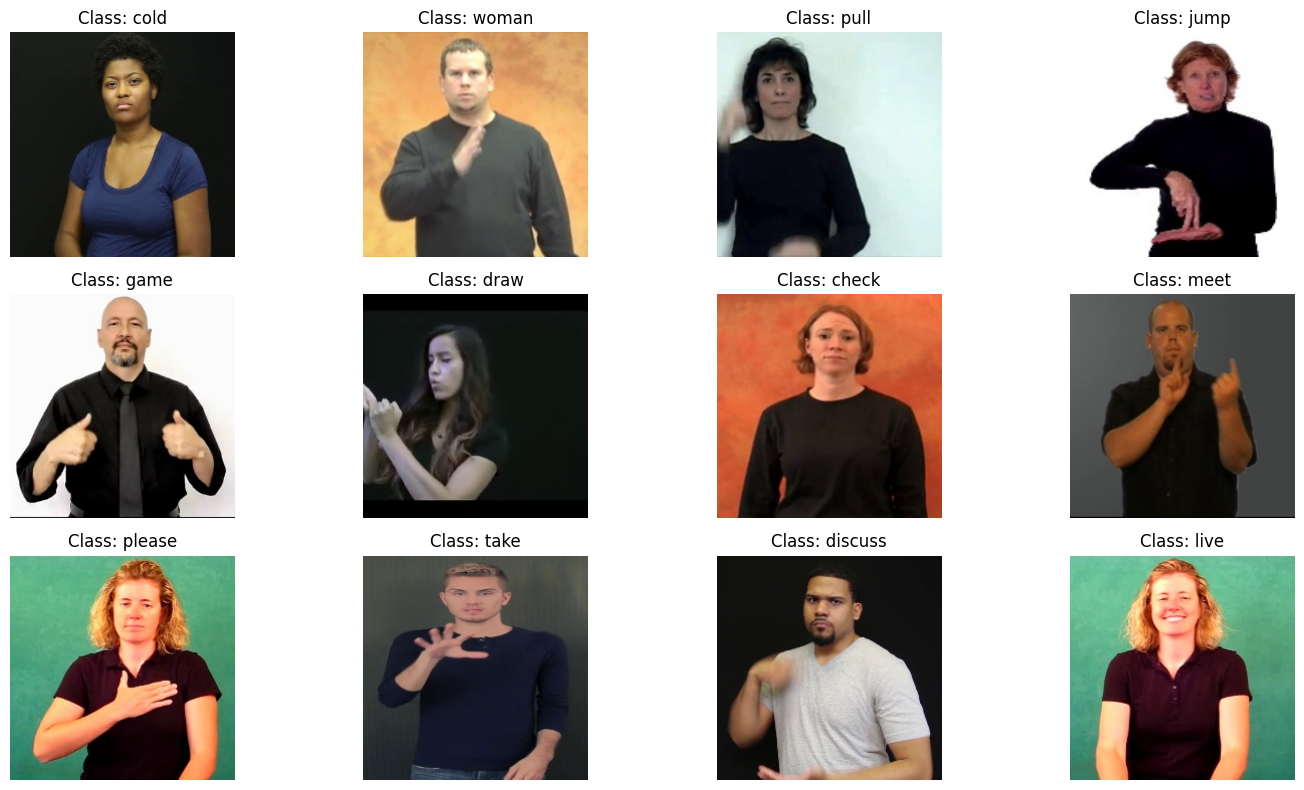

In [26]:
if __name__ == "__main__":
    # Create dataloaders with default params for visualization
    train_loader, val_loader, train_dataset, val_dataset = create_dataloaders(
        DEFAULT_PARAMS['batch_size'], 
        DEFAULT_PARAMS['img_size'],
        DEFAULT_PARAMS['num_workers']
    )
    
    # Visualize sample images
    print("\nVisualizing sample images...")
    
    # Get a batch of training data
    images, labels = next(iter(train_loader))

    # Plot some sample images
    plt.figure(figsize=(15, 8))
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        img = denormalize(images[i]).permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        class_name = idx_to_class[labels[i].item()]
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"sample_images_{timestamp}.png")
    plt.show()


In [31]:
if __name__ == "__main__":
    # Get parameters for training
    if use_optuna and resume_from is None:
        # Run hyperparameter optimization
        print("\nRunning Optuna hyperparameter optimization...")
        best_params = run_hyperparameter_optimization(n_trials=n_trials)
    else:
        if resume_from:
            # Load parameters from checkpoint
            checkpoint = torch.load(resume_from)
            best_params = checkpoint['params']
            print("\nUsing parameters from checkpoint:")
        else:
            # Use default parameters
            best_params = DEFAULT_PARAMS
            print("\nUsing default parameters:")
        
        for param, value in best_params.items():
            print(f"  {param}: {value}")


Running Optuna hyperparameter optimization...


[I 2025-05-18 14:10:38,588] A new study created in RDB with name: asl_recognition_study_20250518_141038


Running hyperparameter optimization with 3 trials...
Loaded 56578 images from 300 classes
Epoch [1/5] Batch [565/2829] Loss: 5.6476 Acc: 0.76%
Epoch [1/5] Batch [1130/2829] Loss: 5.4209 Acc: 0.71%
Epoch [1/5] Batch [1695/2829] Loss: 5.7772 Acc: 0.75%
Epoch [1/5] Batch [2260/2829] Loss: 5.4583 Acc: 0.80%
Epoch [1/5] Batch [2825/2829] Loss: 5.4987 Acc: 0.86%
Epoch [2/5] Batch [565/2829] Loss: 5.3930 Acc: 0.97%
Epoch [2/5] Batch [1130/2829] Loss: 5.6280 Acc: 1.14%
Epoch [2/5] Batch [1695/2829] Loss: 5.0951 Acc: 1.17%
Epoch [2/5] Batch [2260/2829] Loss: 5.2098 Acc: 1.20%
Epoch [2/5] Batch [2825/2829] Loss: 5.6225 Acc: 1.23%
Epoch [3/5] Batch [565/2829] Loss: 5.3489 Acc: 1.45%
Epoch [3/5] Batch [1130/2829] Loss: 5.0249 Acc: 1.53%
Epoch [3/5] Batch [1695/2829] Loss: 4.8304 Acc: 1.70%
Epoch [3/5] Batch [2260/2829] Loss: 5.1045 Acc: 1.81%
Epoch [3/5] Batch [2825/2829] Loss: 5.2850 Acc: 1.87%
Epoch [4/5] Batch [565/2829] Loss: 5.0258 Acc: 2.35%
Epoch [4/5] Batch [1130/2829] Loss: 4.6219 Acc: 2.

[I 2025-05-18 14:23:16,166] Trial 0 finished with value: 4.642554167420054 and parameters: {'batch_size': 16, 'learning_rate': 0.0016977822992995167, 'weight_decay': 0.00013153410006024784, 'dropout_rate': 0.41284056201344554, 'img_size': 224}. Best is trial 0 with value: 4.642554167420054.


Loaded 56578 images from 300 classes
Epoch [1/5] Batch [283/1415] Loss: 5.6933 Acc: 0.49%
Epoch [1/5] Batch [566/1415] Loss: 5.6657 Acc: 0.59%
Epoch [1/5] Batch [849/1415] Loss: 5.6019 Acc: 0.65%
Epoch [1/5] Batch [1132/1415] Loss: 5.6436 Acc: 0.68%
Epoch [1/5] Batch [1415/1415] Loss: 5.5762 Acc: 0.69%
Epoch [2/5] Batch [283/1415] Loss: 5.6052 Acc: 0.78%
Epoch [2/5] Batch [566/1415] Loss: 5.5757 Acc: 0.77%
Epoch [2/5] Batch [849/1415] Loss: 5.5903 Acc: 0.79%


[W 2025-05-18 14:26:57,339] Trial 1 failed with parameters: {'batch_size': 32, 'learning_rate': 0.0026003027287547715, 'weight_decay': 0.0009844773755620637, 'dropout_rate': 0.4717338548431539, 'img_size': 224} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_35/1649601775.py", line 26, in <lambda>
    study.optimize(lambda trial: objective(trial), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_35/3713349416.py", line 44, in objective
    train_loss, train_acc = train_one_epoch(
                            ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_35/1955980527.py", line 26, in train_one_epoch
    running_loss += loss.item() * images.size(0)
                    ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-05-18 14:26:57,341]

KeyboardInterrupt: 

Stopping this optuna search and using parameters from a previous optuna trial

In [34]:
# Use parameters from the successful previous trial
best_params = {
    'batch_size': 32, 
    'learning_rate': 0.00010800203112761688, 
    'weight_decay': 0.0005677421704921649, 
    'dropout_rate': 0.35937814458964, 
    'img_size': 240,
    'num_workers': 4
}

# Merge the dictionaries, with best_params taking precedence
for key, value in DEFAULT_PARAMS.items():
    if key not in best_params:
        best_params[key] = value

print("\nFinal parameters for training:")
for param, value in best_params.items():
    print(f"  {param}: {value}")



Final parameters for training:
  batch_size: 32
  learning_rate: 0.00010800203112761688
  weight_decay: 0.0005677421704921649
  dropout_rate: 0.35937814458964
  img_size: 240
  num_workers: 4
  num_epochs: 20



Starting full training with selected parameters...
Loaded 56578 images from 300 classes
Starting training from epoch 1...
Epoch [1/20] Batch [283/1415] Loss: 5.3099 Acc: 2.26%
Epoch [1/20] Batch [566/1415] Loss: 4.4167 Acc: 4.79%
Epoch [1/20] Batch [849/1415] Loss: 4.3052 Acc: 7.73%
Epoch [1/20] Batch [1132/1415] Loss: 3.9969 Acc: 10.98%
Epoch [1/20] Batch [1415/1415] Loss: 3.4364 Acc: 14.45%
Epoch 1/20: Train Loss: 4.5560, Train Acc: 0.1445, Val Loss: 3.1590, Val Acc: 0.3745
Saved best model at epoch 1
Epoch [2/20] Batch [283/1415] Loss: 2.9860 Acc: 40.72%
Epoch [2/20] Batch [566/1415] Loss: 2.1291 Acc: 43.78%
Epoch [2/20] Batch [849/1415] Loss: 2.5605 Acc: 46.32%
Epoch [2/20] Batch [1132/1415] Loss: 2.2478 Acc: 48.85%
Epoch [2/20] Batch [1415/1415] Loss: 2.1353 Acc: 51.43%
Epoch 2/20: Train Loss: 2.4498, Train Acc: 0.5143, Val Loss: 1.6741, Val Acc: 0.6544
Saved best model at epoch 2
Epoch [3/20] Batch [283/1415] Loss: 1.6434 Acc: 69.75%
Epoch [3/20] Batch [566/1415] Loss: 1.2117 Ac

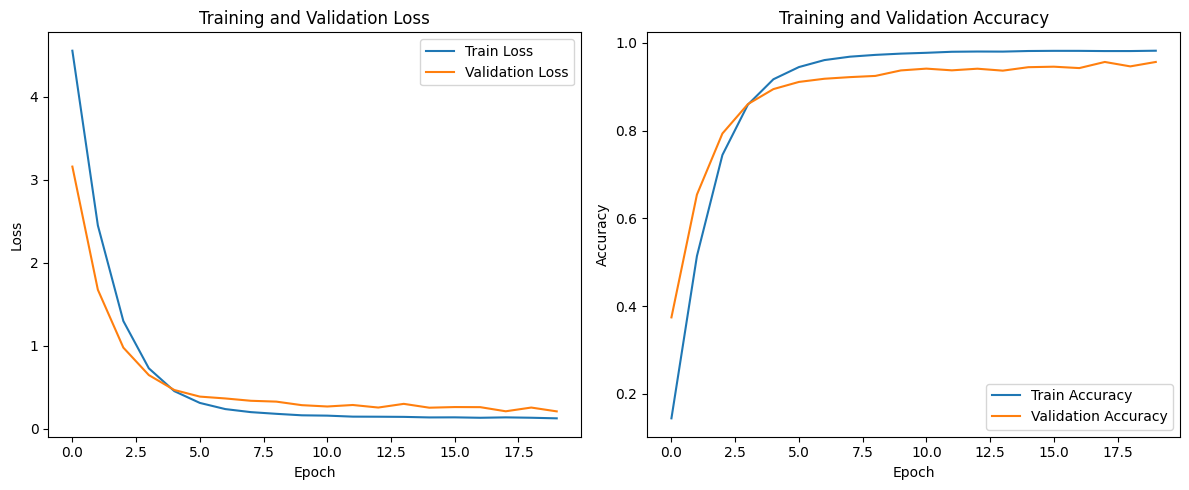

In [35]:
if __name__ == "__main__":
    # Train the model
    print("\nStarting full training with selected parameters...")
    history, best_val_loss, best_model_path = train_model(best_params, resume_from)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"training_metrics_{timestamp}.png")
    plt.show()
    
    # Save training history
    history_file = OUTPUT_DIR / f"training_history_{timestamp}.json"
    with open(history_file, 'w') as f:
        # Convert numpy values to float for JSON serialization
        for key in history:
            history[key] = [float(val) for val in history[key]]
        json.dump(history, f, indent=4)

In [36]:
if __name__ == "__main__":
    # Evaluate the best model
    print("\nEvaluating the best model...")
    
    # Load best model and parameters
    checkpoint = torch.load(best_model_path)
    model = ASLRecognitionModel(
        num_classes=len(class_to_idx), 
        dropout_rate=checkpoint['params']['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    print(f"Loaded model from {best_model_path}")
    print(f"Model was trained for {checkpoint['epoch'] + 1} epochs")
    print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")


Evaluating the best model...
Loaded model from /kaggle/working/checkpoints/asl_best_20250518_132050.pth
Model was trained for 20 epochs
Best validation loss: 0.2080
Best validation accuracy: 0.9567


Loaded 56578 images from 300 classes
Getting predictions for validation set...


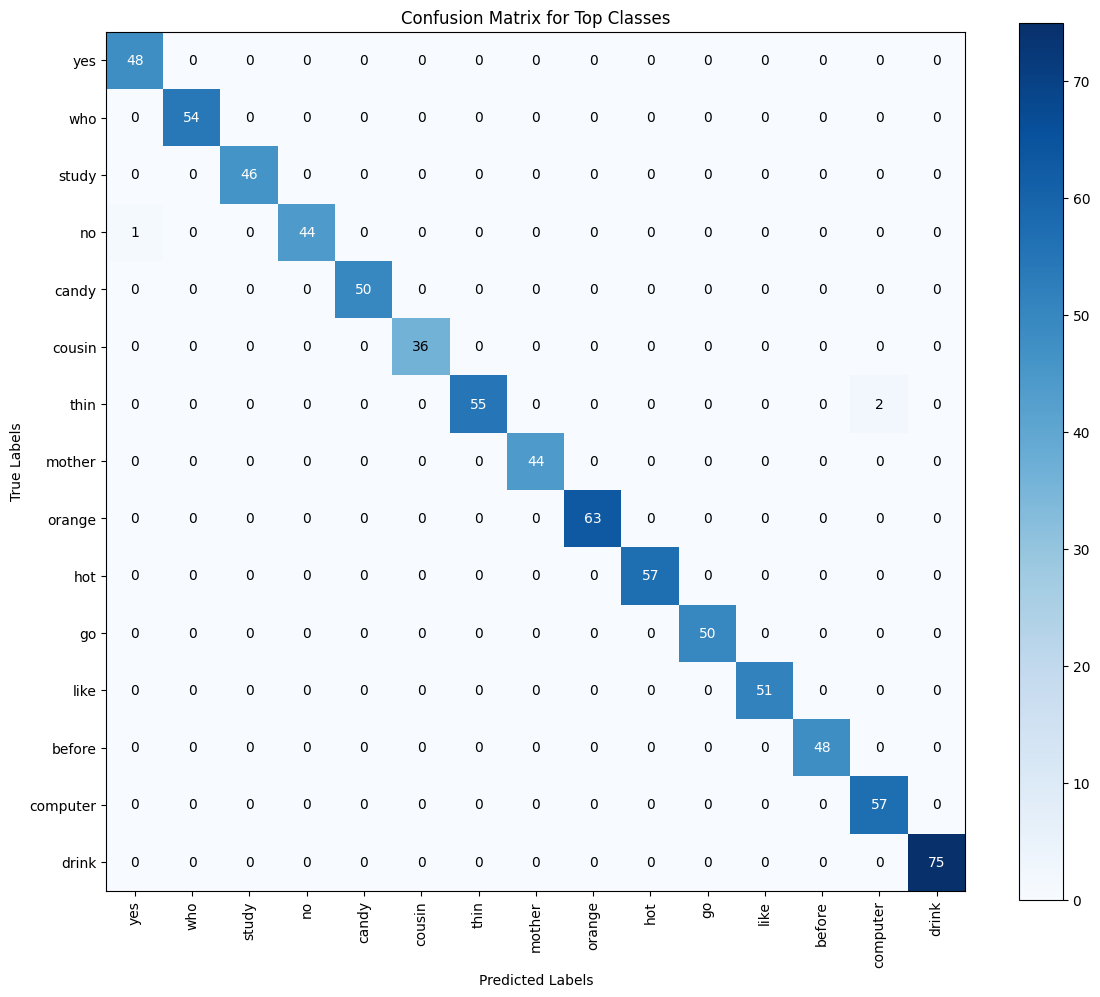

Classification Report:
              precision    recall  f1-score   support

       about       1.00      1.00      1.00        30
    accident       1.00      0.90      0.95        49
      africa       1.00      0.98      0.99        52
       again       1.00      0.95      0.97        39
         all       1.00      0.93      0.96        43
      always       1.00      0.97      0.98        32
      animal       0.89      1.00      0.94        32
       apple       1.00      0.98      0.99        53
     approve       1.00      0.88      0.94        33
       argue       0.93      0.95      0.94        39
      arrive       0.97      0.97      0.97        39
        baby       0.96      0.89      0.93        28
        back       1.00      1.00      1.00        27
    backpack       0.97      0.95      0.96        38
         bad       0.97      0.97      0.97        39
        bake       0.97      1.00      0.98        29
     balance       0.98      1.00      0.99        44
    

In [37]:
if __name__ == "__main__":
    # Create dataloaders with the same parameters
    _, val_loader, _, _ = create_dataloaders(
        checkpoint['params']['batch_size'], 
        checkpoint['params']['img_size'],
        checkpoint['params']['num_workers']
    )
    
    # Get predictions for validation set
    def get_all_predictions(model, dataloader, device):
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return np.array(all_preds), np.array(all_labels)
    
    print("Getting predictions for validation set...")
    y_pred, y_true = get_all_predictions(model, val_loader, device)
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix for the top classes
    top_n_classes = 15  # Adjust based on your needs
    plt.figure(figsize=(12, 10))
    
    # Get classes with most samples
    top_class_indices = np.argsort([class_counts[idx_to_class[i]] for i in range(len(class_to_idx))])[-top_n_classes:]
    top_classes = [idx_to_class[i] for i in top_class_indices]
    
    # Filter confusion matrix for top classes
    top_conf_matrix = conf_matrix[np.ix_(top_class_indices, top_class_indices)]
    
    # Plot
    plt.imshow(top_conf_matrix, cmap='Blues')
    plt.colorbar()
    plt.xticks(np.arange(len(top_classes)), top_classes, rotation=90)
    plt.yticks(np.arange(len(top_classes)), top_classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Top Classes')
    
    # Add text annotations
    thresh = top_conf_matrix.max() / 2
    for i in range(len(top_classes)):
        for j in range(len(top_classes)):
            plt.text(j, i, top_conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if top_conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"confusion_matrix_{timestamp}.png")
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(
        y_true, y_pred, 
        target_names=[idx_to_class[i] for i in range(len(class_to_idx))]
    ))
    
    # Save classification report
    report = classification_report(
        y_true, y_pred, 
        target_names=[idx_to_class[i] for i in range(len(class_to_idx))],
        output_dict=True
    )
    report_file = OUTPUT_DIR / f"classification_report_{timestamp}.json"
    with open(report_file, 'w') as f:
        # Convert numpy values to float for JSON serialization
        for class_name in report:
            if isinstance(report[class_name], dict):
                for metric in report[class_name]:
                    report[class_name][metric] = float(report[class_name][metric])
            else:
                report[class_name] = float(report[class_name])
        json.dump(report, f, indent=4)

In [38]:
if __name__ == "__main__":
    # Measure inference time
    print("\nMeasuring inference time...")
    
    def measure_inference_time(model, num_iterations=100):
        model.eval()
        
        # Create random input tensor
        img_size = checkpoint['params'].get('img_size', 224)
        dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
        
        # Warm-up
        with torch.no_grad():
            for _ in range(10):
                _ = model(dummy_input)
        
        # Measure time
        start_time = time.time()
        with torch.no_grad():
            for _ in range(num_iterations):
                _ = model(dummy_input)
        end_time = time.time()
        
        avg_time = (end_time - start_time) / num_iterations
        return avg_time * 1000  # Convert to milliseconds
    
    inference_time = measure_inference_time(model)
    fps = 1000 / inference_time
    
    print(f"Average inference time: {inference_time:.2f} ms")
    print(f"Frames per second: {fps:.2f}")
    
    # Export model to TorchScript format for deployment
    print("\nExporting model to TorchScript format...")
    
    model.eval()
    img_size = checkpoint['params'].get('img_size', 224)
    example_input = torch.rand(1, 3, img_size, img_size).to(device)
    traced_model = torch.jit.trace(model, example_input)
    torch_script_path = OUTPUT_DIR / f"asl_torchscript_{timestamp}.pt"
    traced_model.save(str(torch_script_path))
    print(f"Exported TorchScript model to {torch_script_path}")


Measuring inference time...
Average inference time: 5.23 ms
Frames per second: 191.04

Exporting model to TorchScript format...
Exported TorchScript model to /kaggle/working/output/asl_torchscript_20250518_132050.pt



Testing prediction on sample images...


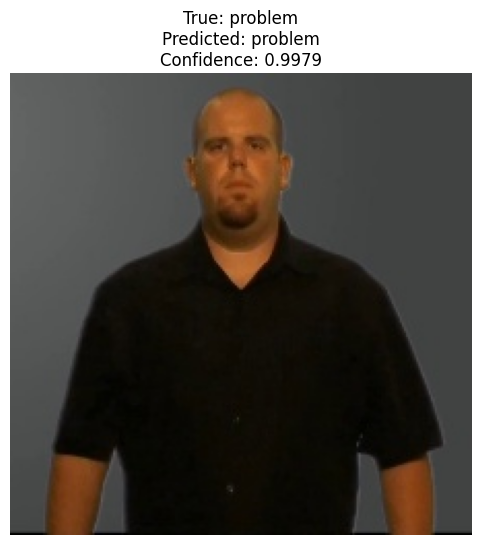

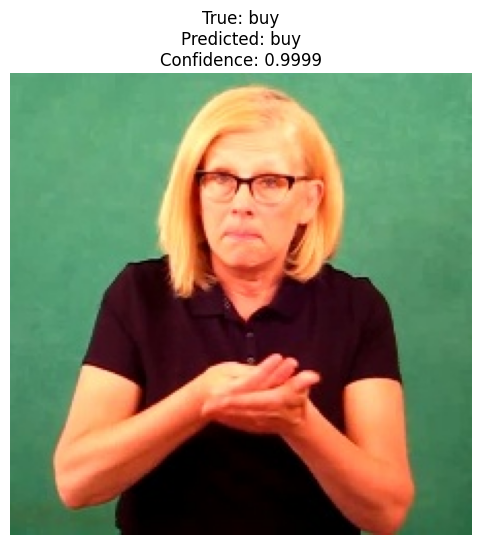

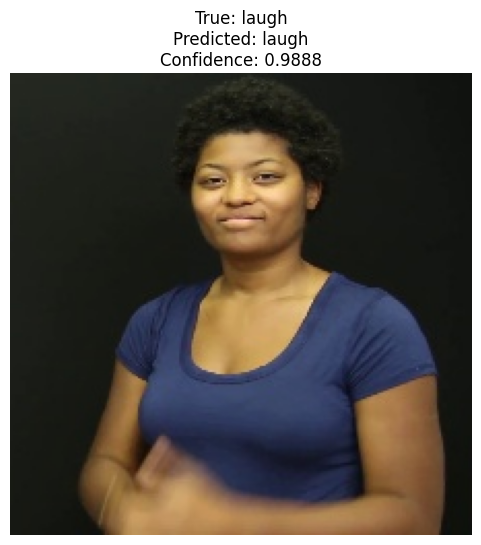


Training and evaluation complete!
All outputs saved to /kaggle/working/output
Best model saved to /kaggle/working/checkpoints/asl_best_20250518_132050.pth


In [39]:
if __name__ == "__main__":
    # Function for real-time inference from an image
    def predict_image(image_path, model):
        # Create transformer for single image
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])
        
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Inference
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
        # Get prediction
        pred_class_idx = predicted.item()
        pred_class = idx_to_class[pred_class_idx]
        confidence = probabilities[0][pred_class_idx].item()
        
        return pred_class, confidence
    
    # Test on some random validation images
    print("\nTesting prediction on sample images...")
    sample_image_paths = []
    for class_dir in random.sample(list(class_dirs), min(3, len(class_dirs))):
        image_files = list(class_dir.glob("*/*.jpg"))
        if image_files:
            sample_image_paths.append(random.choice(image_files))
    
    for image_path in sample_image_paths:
        true_class = image_path.parent.parent.name
        predicted_class, confidence = predict_image(image_path, model)
        
        # Display image with prediction
        image = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(np.array(image))
        plt.title(f"True: {true_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.4f}")
        plt.axis('off')
        plt.show()
    
    print("\nTraining and evaluation complete!")
    print(f"All outputs saved to {OUTPUT_DIR}")
    print(f"Best model saved to {best_model_path}")